In this section we will provide the results from four modeling approaches.  Three of these 
modeling approaches are defined for you, and you get to choose the fourth approach from the 
list of choices.   
    - For each model provide any relevant or useful model output and a table of the model
    performance in-sample (i.e. on the training data set) and out-of-sample (i.e. on the test data set).   
    - The metrics to be measured are:   
        (1) true positive rate or sensitivity  
        (2) false positive rate  
        (3) the accuracy.  
 
5.a Random Forest  
    - Include the variable importance plot.  
 
5.b Gradient Boosting  
    - Use GBM or XGBoost packages.  Include the variable importance plot.  

5.c Logistic Regression with Variable Selection   
    - Random Forest and Gradient Boosting will identify a pool of interesting predictor 
    variables.  Use that information to help you choose an initial pool of predictor variables.   
    List your initial pool of predictor variables in a table.   
    - Choose a variable selection algorithm.  Use that variable selection algorithm to arrive at 
    an ‘optimal’ logistic regression model.  
    - Since this is a linear model, you should provide a table of the model coefficients and 
    their p-values.  
 
5.d Your Choice – CHAID, Neural Network, SVM, or some other method appropriate for 
binary classification.   
    - Provide the relevant output for the model of choice.  For example SVM has margin 
    plots that are useful, and a neural network allows you to plot out the network topology.  If 
    your chosen method has a ‘standard’ plot that is typically shown with it, then we all 
    expect to see that plot, and you should be providing that plot with the model.

In [52]:
### ref https://blog.jovian.ai/machine-learning-with-python-implementing-xgboost-and-random-forest-fd51fa4f9f4c#b9a9
# !pip install numpy pandas matplotlib seaborn --quiet
# !pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet
# !pip install pyreadr

#importing dataset
import os
# import opendatasets as od
import pandas as pd
import numpy as np
import pyreadr

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics

import time

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)


In [53]:
credit_card_default_eng = pd.read_csv('./Data/credit_card_default_final.csv')

display(credit_card_default_eng.describe())
display(credit_card_default_eng.head())
credit_card_default = credit_card_default_eng.copy()
df_test_over = credit_card_default_eng.copy()

,Unnamed: 0,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,14999.500000,3.99390,44976.945200,5275.232094,0.576423,0.375468,-0.090664,6.057244e+04,1.584823e+04,0.682200,1.743900,0.221200,1.603733,1.853133,1.551867,2.466300
std,8660.398374,0.95845,63260.721860,10137.946323,16.499616,0.355618,0.279674,7.840481e+04,3.793356e+04,1.073518,0.830864,0.415062,0.489129,0.790349,0.521970,0.904558
min,0.000000,3.00000,-56043.166667,0.000000,0.000000,-0.232590,-4.700400,-6.029000e+03,0.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,7499.750000,3.00000,4781.333333,1113.291667,0.047855,0.028925,-0.146863,1.006000e+04,2.198000e+03,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000
50%,14999.500000,4.00000,21051.833333,2397.166667,0.197668,0.286554,-0.004382,3.120850e+04,5.000000e+03,0.000000,1.000000,0.000000,2.000000,2.000000,2.000000,2.000000
75%,22499.250000,5.00000,57104.416667,5583.916667,0.903817,0.692718,0.028105,7.959900e+04,1.210000e+04,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,3.000000
max,29999.000000,8.00000,877313.833333,627344.333333,2667.199955,5.537758,1.791100,1.664089e+06,1.684259e+06,8.000000,3.000000,1.000000,2.000000,6.000000,3.000000,4.000000


,Unnamed: 0,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,data.group,DEFAULT,SEX,EDUCATION,MARRIAGE,AGE
0,0,3.0,1284.000000,114.833333,0.800000,0.064200,-0.195650,3913.0,689.0,2.0,1,1,2,2,1,1
1,1,3.0,2846.166667,833.333333,0.193583,0.023987,0.006442,3455.0,2000.0,2.0,3,1,2,2,2,2
2,2,4.0,16942.166667,1836.333333,0.083968,0.187133,-0.158789,29239.0,5000.0,0.0,1,0,2,2,2,2
3,3,4.0,38555.666667,1398.000000,0.039794,0.769153,-0.360620,49291.0,2019.0,0.0,3,0,2,2,1,3
4,4,6.0,18223.166667,9841.500000,0.471997,0.364513,0.210580,35835.0,36681.0,0.0,3,0,1,2,1,4


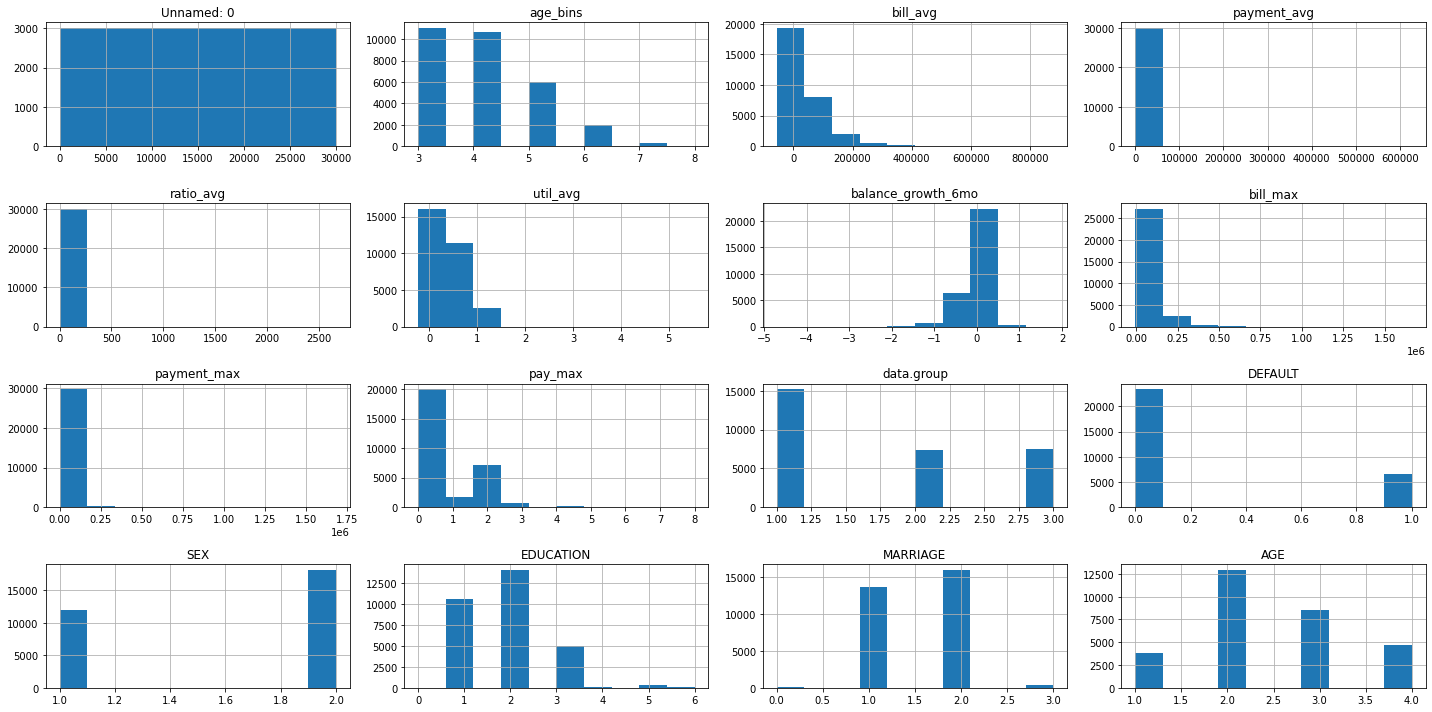

In [54]:
hist = credit_card_default.hist(bins=10, figsize=(20, 10))
plt.tight_layout()


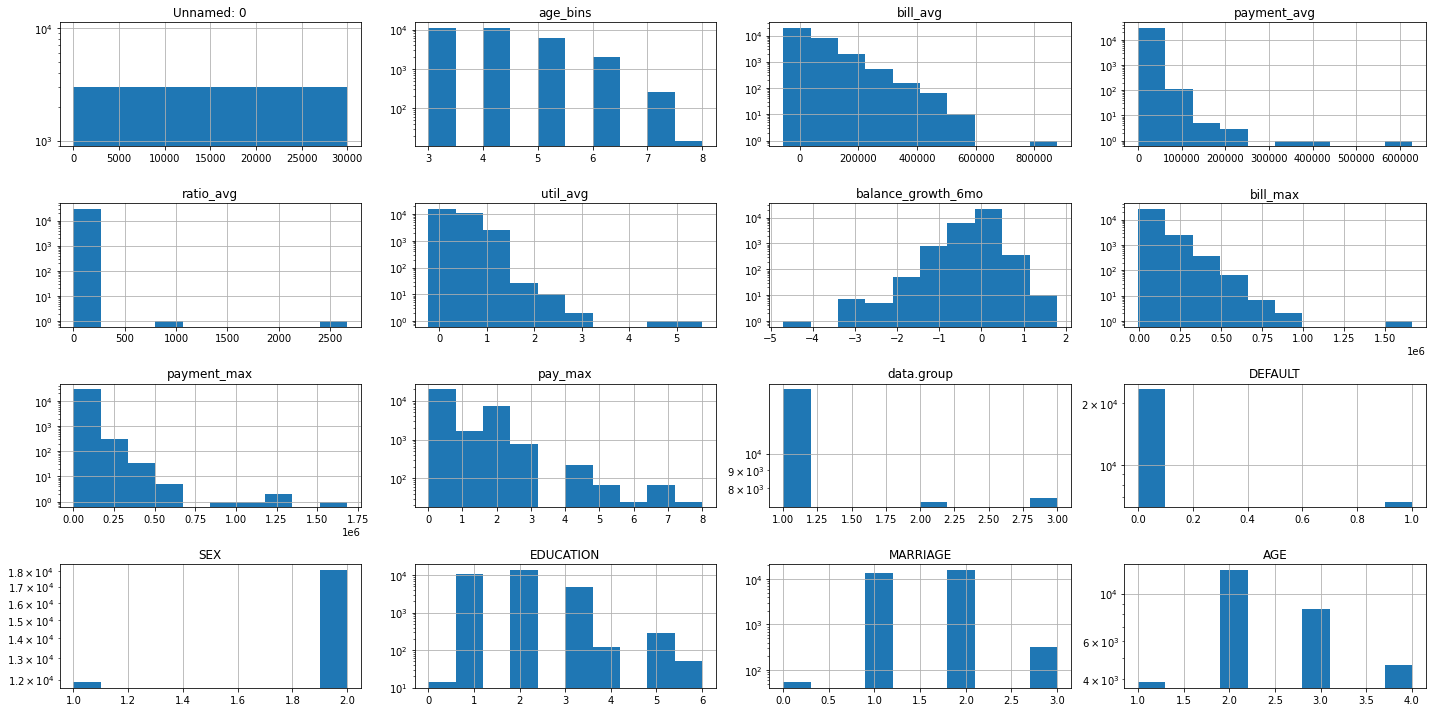

In [55]:
hist = credit_card_default.hist(bins=10, log=True, figsize=(20, 10))
plt.tight_layout()


reviewing log vs raw distributions, nearly all of the fields approach a more normal distribution through log, so we will test log-transforming all except age and sex

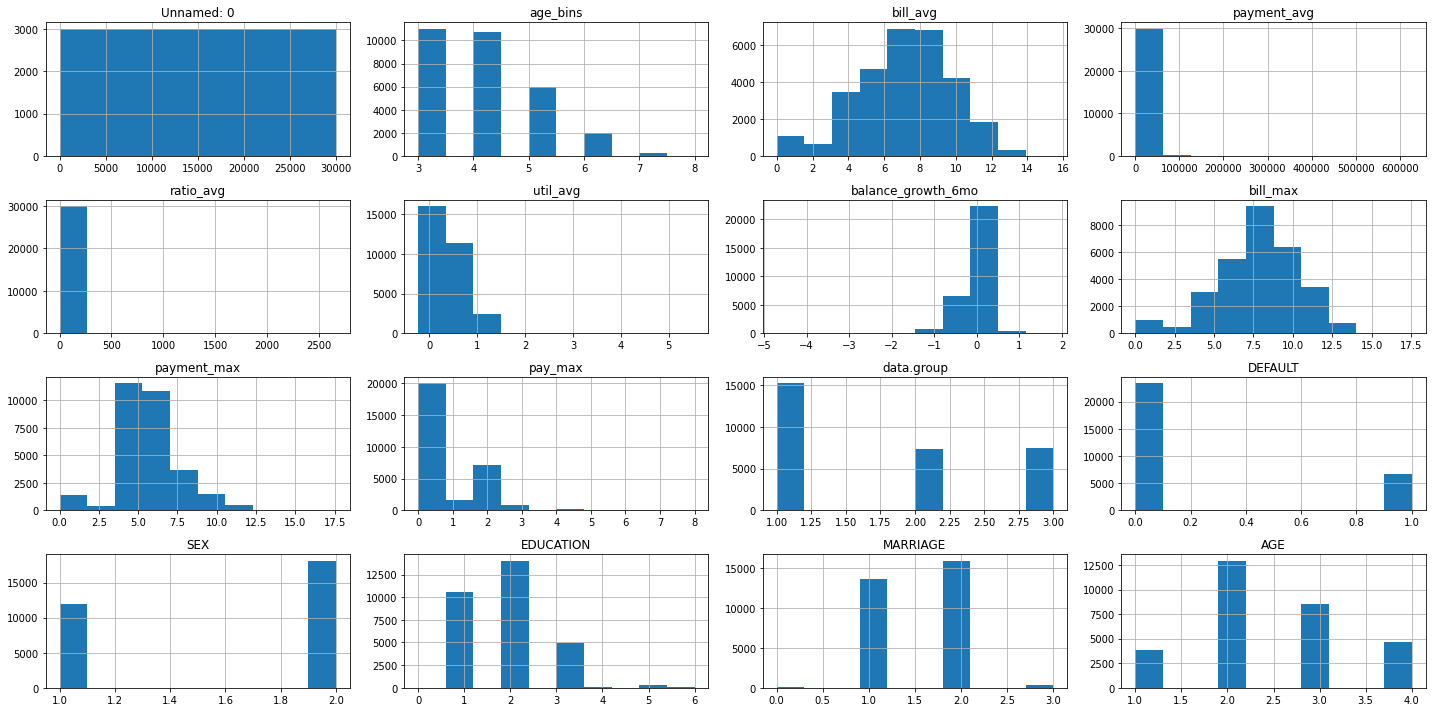

In [56]:
def exp_xform(x,power=.2):
    return np.power(x,power)

cols2xform = ['bill_avg', 'bill_max', 'payment_max']

df_test_over[cols2xform] = df_test_over[cols2xform].apply(exp_xform)
df_test_over[cols2xform] = np.nan_to_num(df_test_over[cols2xform])
hist = df_test_over.hist(bins=10, figsize=(20, 10))
plt.tight_layout()



Prep for modeling

In [57]:
ccd_train = df_test_over[df_test_over['data.group']==1].drop(columns=['data.group'])
ccd_test = df_test_over[df_test_over['data.group']==2].drop(columns=['data.group'])
ccd_validate = df_test_over[df_test_over['data.group']==3].drop(columns=['data.group'])

print('train data size:', ccd_train.shape)
print('test data size:', ccd_test.shape)
print('validate data size:', ccd_validate.shape)

train data size: (15180, 15)
test data size: (7323, 15)
validate data size: (7497, 15)


In [58]:
X_train = ccd_train.drop(columns=['DEFAULT','Unnamed: 0'])
X_test = ccd_test.drop_duplicates(subset=['Unnamed: 0']).drop(columns=['DEFAULT','Unnamed: 0'])

y_train = ccd_train['DEFAULT']
y_test = ccd_test.drop_duplicates(subset=['Unnamed: 0'])['DEFAULT']

In [59]:
X_train

,age_bins,bill_avg,payment_avg,ratio_avg,util_avg,balance_growth_6mo,bill_max,payment_max,pay_max,SEX,EDUCATION,MARRIAGE,AGE
0,3.0,4.185169,114.833333,0.800000,0.064200,-0.195650,5.230003,3.695250,2.0,2,2,1,1
2,4.0,7.011223,1836.333333,0.083968,0.187133,-0.158789,7.819743,5.492803,0.0,2,2,2,2
5,4.0,8.312406,1295.333333,0.042020,0.792363,-0.895620,9.157505,4.781762,0.0,1,1,2,3
9,4.0,5.375038,2354.833333,0.816130,0.216783,0.650350,6.740280,6.650211,0.0,1,3,2,2
11,6.0,6.817572,11051.333333,0.803041,0.062172,0.038562,7.406454,7.407384,2.0,2,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29990,5.0,10.157102,3788.833333,0.039662,0.776415,-0.633214,10.682470,5.875159,0.0,1,2,1,3
29991,4.0,4.781762,0.000000,0.000000,0.011905,0.000000,4.781762,0.000000,3.0,1,2,1,2
29994,4.0,9.527119,3583.333333,0.043782,0.984129,0.125625,9.625058,5.875159,2.0,1,2,2,2
29995,4.0,10.386737,7091.666667,0.121471,0.561065,-0.716868,11.581504,7.247797,0.0,1,3,1,3


In [60]:
all_features = X_train.columns
all_features = all_features.tolist()

In [61]:
numerical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind in ['i','f']]
display(numerical_features)
categorical_features = [c for c, dtype in zip(X_train.columns, X_train.dtypes)
                     if dtype.kind not in ['i','f']]
display(categorical_features)

['age_bins',
 'bill_avg',
 'payment_avg',
 'ratio_avg',
 'util_avg',
 'balance_growth_6mo',
 'bill_max',
 'payment_max',
 'pay_max',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE']

[]

In [62]:
def log_transform(x):
    print(x)
    return np.log(x + 1)

preprocessor = make_column_transformer(
    
    (make_pipeline(
    SimpleImputer(strategy = 'median'),
    # KNNImputer(n_neighbors=2, weights="uniform"),
    # FunctionTransformer(log_transform), 
    MinMaxScaler()), numerical_features),
    
    (make_pipeline(
    SimpleImputer(strategy = 'constant'),  # ValueError: 'fill_value'=missing is invalid. Expected a numerical value when imputing numerical data
    OneHotEncoder(categories = 'auto', handle_unknown = 'ignore')), categorical_features),
    
)

In [63]:
preprocessor_best = make_pipeline(preprocessor, 
                                  VarianceThreshold(), 
                                  SelectKBest(f_classif, k = 'all')
                                 )


5.c LR

In [64]:
%%time
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train)


CPU times: total: 78.1 ms
Wall time: 75.4 ms


LogisticRegression()

,precision,recall,f1-score,support
0,0.81,0.97,0.88,5766.00
1,0.55,0.15,0.24,1557.00
accuracy,0.79,0.79,0.79,0.79
macro avg,0.68,0.56,0.56,7323.00
weighted avg,0.75,0.79,0.74,7323.00


[[5574  192]
 [1320  237]]


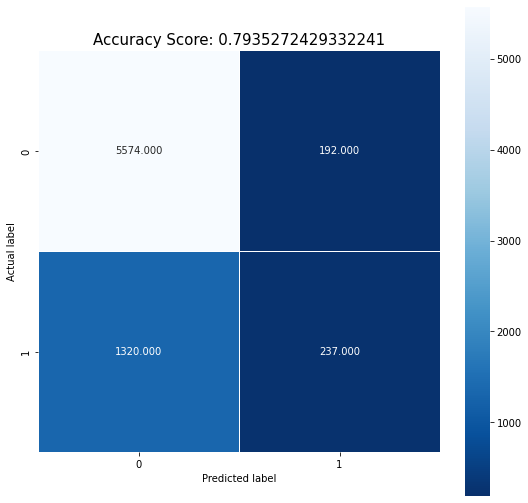

In [65]:
# Ref: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
# print(classification_report(y_test, predictions))
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
display(df.round(2))

cm = confusion_matrix(y_test, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


#### KS & ROC

In [66]:
def run_preds(x):
    prob_predictions = model.predict_proba(x)
    df = pd.DataFrame(prob_predictions)
    df['p'] = df.max(axis=1)
    df['y'] = df.idxmax(axis=1)
    return df

In [67]:
# Ref: https://www.listendata.com/2019/07/KS-Statistics-Python.html
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 20)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,21)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 100)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)



In [68]:
from sklearn.metrics import roc_curve,roc_auc_score

def plot_roc_curve(df): 
  fpr , tpr , thresholds = roc_curve( df.y , df.p)
  auc_score=roc_auc_score(df.y , df.p) 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.text(x=.1,y=.8,s="ROC curve (area = %0.2f)" % auc_score)
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  
  plt.show() 
  

#### Train

In [69]:
df_train = run_preds(X_train)

In [70]:
ks(data=df_train,target="y", prob="p")


        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.931774  1.000000      57        702      6.32%         4.92%   
2       0.916646  0.931764       7        752      0.78%         5.27%   
3       0.904264  0.916613      10        749      1.11%         5.25%   
4       0.893333  0.904259       8        751      0.89%         5.26%   
5       0.884185  0.893320       4        755      0.44%         5.29%   
6       0.875784  0.884180       3        756      0.33%         5.29%   
7       0.868608  0.875783       4        755      0.44%         5.29%   
8       0.861862  0.868599       3        756      0.33%         5.29%   
9       0.854632  0.861857       2        757      0.22%         5.30%   
10      0.847193  0.854624       1        758      0.11%         5.31%   
11      0.839221  0.847191       5        754      0.55%         5.28%   
12      0.829138  0.839219       7    

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.931774,1.000000,57,702,6.32%,4.92%,6.32%,4.92%,1.4
2,0.916646,0.931764,7,752,0.78%,5.27%,7.10%,10.18%,-3.1
3,0.904264,0.916613,10,749,1.11%,5.25%,8.20%,15.43%,-7.2
4,0.893333,0.904259,8,751,0.89%,5.26%,9.09%,20.69%,-11.6
5,0.884185,0.893320,4,755,0.44%,5.29%,9.53%,25.98%,-16.4
6,0.875784,0.884180,3,756,0.33%,5.29%,9.87%,31.27%,-21.4
7,0.868608,0.875783,4,755,0.44%,5.29%,10.31%,36.56%,-26.2
8,0.861862,0.868599,3,756,0.33%,5.29%,10.64%,41.85%,-31.2
9,0.854632,0.861857,2,757,0.22%,5.30%,10.86%,47.16%,-36.3


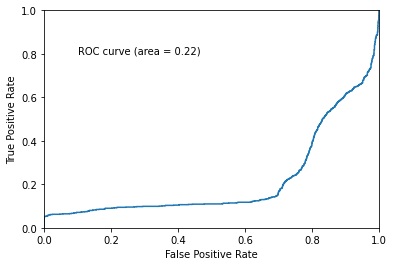

In [71]:

plot_roc_curve (df_train) 


#### Test

In [72]:
df_test = run_preds(X_test)

In [73]:
ks(data=df_test,target="y", prob="p")


        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.932622  0.997753      25        342      5.83%         4.96%   
2       0.917579  0.932581       1        365      0.23%         5.29%   
3       0.905534  0.917555       1        365      0.23%         5.29%   
4       0.894013  0.905522       3        363      0.70%         5.27%   
5       0.884160  0.893990       3        363      0.70%         5.27%   
6       0.876698  0.884120       3        363      0.70%         5.27%   
7       0.868971  0.876664       2        364      0.47%         5.28%   
8       0.861637  0.868970       1        365      0.23%         5.29%   
9       0.854388  0.861627       3        363      0.70%         5.27%   
10      0.847240  0.854354       1        365      0.23%         5.29%   
11      0.839143  0.847190       6        361      1.40%         5.24%   
12      0.828712  0.838996       4    

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.932622,0.997753,25,342,5.83%,4.96%,5.83%,4.96%,0.9
2,0.917579,0.932581,1,365,0.23%,5.29%,6.06%,10.26%,-4.2
3,0.905534,0.917555,1,365,0.23%,5.29%,6.29%,15.55%,-9.3
4,0.894013,0.905522,3,363,0.70%,5.27%,6.99%,20.82%,-13.8
5,0.884160,0.893990,3,363,0.70%,5.27%,7.69%,26.08%,-18.4
6,0.876698,0.884120,3,363,0.70%,5.27%,8.39%,31.35%,-23.0
7,0.868971,0.876664,2,364,0.47%,5.28%,8.86%,36.63%,-27.8
8,0.861637,0.868970,1,365,0.23%,5.29%,9.09%,41.92%,-32.8
9,0.854388,0.861627,3,363,0.70%,5.27%,9.79%,47.19%,-37.4


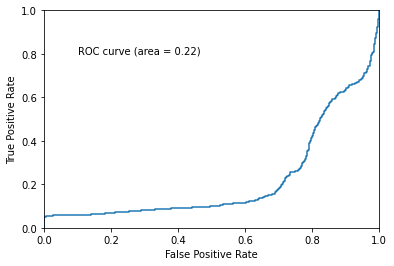

In [74]:

plot_roc_curve (df_test) 


In [85]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
pd.DataFrame(result.summary().tables[0])
pd.DataFrame(result.summary().tables[1])


Optimization terminated successfully.
         Current function value: 0.461336
         Iterations 7


,0,1,2,3,4,5,6
0,,coef,std err,z,P>|z|,[0.025,0.975]
1,age_bins,-0.0262,0.037,-0.709,0.479,-0.098,0.046
2,bill_avg,0.0221,0.047,0.475,0.635,-0.069,0.113
3,payment_avg,2.468e-06,3.45e-06,0.715,0.475,-4.3e-06,9.23e-06
4,ratio_avg,-0.0019,0.003,-0.620,0.535,-0.008,0.004
5,util_avg,0.8216,0.093,8.788,0.000,0.638,1.005
6,balance_growth_6mo,-0.2944,0.088,-3.351,0.001,-0.467,-0.122
7,bill_max,-0.1244,0.047,-2.660,0.008,-0.216,-0.033
8,payment_max,-0.0955,0.018,-5.356,0.000,-0.130,-0.061
9,pay_max,0.7197,0.021,34.966,0.000,0.679,0.760
